<a href="https://colab.research.google.com/github/noahrychener/Data-analysis-NMR-kinetics/blob/main/2023_01_17_Pre_processing_of_the_raw_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# O. Installations and setup of workspace

In [ ]:
pip install brokenaxes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from google.colab import drive
import datetime  # Import the datetime module
import xml.etree.ElementTree as ET  # Import the XML parsing library
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Mount directory and the data file
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Processing of raw input
Sampled from NRY kinetics v11

In [ ]:
# Import necessary libraries for data processing, plotting, and file operations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from google.colab import drive
import datetime  # Import the datetime module
import xml.etree.ElementTree as ET  # Import the XML parsing library
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Mount Google Drive directory and define input and output directory paths
drive.mount('/content/drive')

# Define the directory paths
input_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/input_test/presentation/N1'
output_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/output_test/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Define the variable float number for multiplication
# Prompt the user to enter the concentration in []
conc = float(input("Enter the concentration of the internal standard in [mM]: "))

def create_run_subfolder(output_directory, filename):
    """
    Creates a subfolder with a unique name based on the current timestamp and a specified filename.
    The subfolder is created within the given output directory.

    Parameters:
    output_directory (str): The path of the output directory where the subfolder will be created.
    filename (str): The filename to be included in the subfolder's name.

    Returns:
    str: The path to the newly created subfolder.
    """
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M")
    subfolder_name = f"{timestamp}_{filename}"
    run_output_directory = os.path.join(output_directory, subfolder_name)
    os.makedirs(run_output_directory, exist_ok=True)
    return run_output_directory

def process_dataframe(df, conc, run_output_directory):
    """
    Processes a DataFrame by cleaning, normalizing, and applying a concentration factor.
    It also saves the DataFrame at each step of processing.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be processed.
    conc (float): The concentration factor to be applied.
    run_output_directory (str): Directory path where processed data should be saved.

    Returns:
    pandas.DataFrame: The processed DataFrame.
    """

    # Extract the divisors from the second row
    divisors = df.iloc[1].to_dict()

    # Drop the first two rows
    df = df.iloc[2:].copy()

    # Convert divisor values to float
    divisors = {key: float(val) for key, val in divisors.items()}

    # Drop columns with all '0' values
    df = df.loc[:, (df != '0').any()]

    # Convert columns to numeric, handling errors gracefully
    df = df.apply(pd.to_numeric, errors='coerce')

    # Apply the custom converter function to replace commas with periods
    df = df.applymap(lambda value: float(value.replace(',', '.')) if isinstance(value, str) else value)

    # Convert time column to hours
    df.iloc[:, 0] = df.iloc[:, 0] / 3600

    # Process the DataFrame (Divide, Normalize, Multiply)
    divisors_series = pd.Series(divisors).reindex(df.columns[1:-1])
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1] / divisors_series
    last_column = df.iloc[:, -1].to_numpy()
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1].to_numpy() / last_column[:, np.newaxis]
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1] * conc

    # Save and print the DataFrame after each step
    for step_name in ["1_cleaned_data.csv", "2_divided_data.csv", "3_normalized_data.csv", "4_multiplied_data.csv"]:
        step_output_path = os.path.join(run_output_directory, step_name)
        df.to_csv(step_output_path, index=False)
        print(f"{step_name} saved in {run_output_directory}")

    return df


# Initialize a list to store header information
header_list = []

def process_data_file(file_path, conc, filename, output_directory):
    """
    Processes a single data file. It creates a run-specific subfolder, reads the file into a DataFrame,
    processes the DataFrame, and then creates scatter plots for each data column.

    Parameters:
    file_path (str): Path to the data file to be processed.
    conc (float): Concentration factor to be applied during processing.
    filename (str): Name of the file, used for subfolder creation.
    output_directory (str): Base directory for output files.

    Returns:
    None
    """

    # Create a subfolder for the current run with timestamp and filename
    filename = os.path.basename(file_path)
    run_output_directory = create_run_subfolder(output_directory, filename)

    # Read CSV file into a Pandas DataFrame
    data = pd.read_csv(file_path, sep=';', header=None, dtype=str)

    # Store the header information in the header_list
    header_info = data.iloc[:1]  # Assuming the header is in the first two rows
    header_list.append(header_info)
    print(header_list)

    # Process the DataFrame using the updated function, passing run_output_directory
    data = process_dataframe(data, conc, run_output_directory)

    # Extract time and data columns
    time = data.iloc[:, 0]
    data_columns = data.columns[1:-1]

    create_scatter_plots_for_degrees(time, data, data_columns, run_output_directory, filename, output_directory)


def create_scatter_plots_for_degrees(time, data, data_columns, run_output_directory, filename, output_directory):
    """
    Creates scatter plots for each column in the given DataFrame.
    The plots are saved as PNG files in the specified output directory.

    Parameters:
    time (pandas.Series): Time data for the x-axis.
    data (pandas.DataFrame): DataFrame containing data to be plotted.
    data_columns (list of str): List of column names to be plotted.
    run_output_directory (str): Directory path to save the plots.
    filename (str): Base filename for saving the plots.
    output_directory (str): Base directory for output files.

    Returns:
    None
    """

    num_segments = len(data_columns)
    monochromatic_cmap = plt.cm.Blues

    # Create a list of unique colors for each column
    segmented_colors = [monochromatic_cmap(i / num_segments) for i in range(num_segments)]

    # Create a figure with a specific size (in inches) and resolution (dpi)
    plt.figure(dpi=800)

    # Process and plot data for each CSV file in the input directory
    for i, col in enumerate(data_columns):
        marker_color = segmented_colors[i]  # Get the color for the scatter plot

        plt.scatter(time, data[col], label=col, color=marker_color, edgecolors='black', linewidth=0.5)

        X = time.values.reshape(-1, 1)
        y = data[col].values

    plt.title(f"{filename} Kinetics")
    plt.xlabel("Time [h]")
    plt.ylabel('C [mM]')
    plt.legend(loc='best',
               # bbox_to_anchor=(1, 0.5),
               prop={'size': 10})

    # Save the plot as a .png file in the subfolder
    output_filename = os.path.splitext(filename)[0] + "_plot.png"
    output_path = os.path.join(run_output_directory, output_filename)
    plt.savefig(output_path)
    plt.show()
    plt.close()
# Initialize a list to store the processed data frames
processed_data_frames = []

# Process each data file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(input_directory, filename)
        process_data_file(file_path, conc, filename, output_directory)

# Notify completion of data processing and saving of plots
print("Plots and Data saved to their respective subfolders in:", output_directory)

MessageError: Error: credential propagation was unsuccessful

# 2. Replicates
Reading in processed .txt files

In [ ]:
# Define the directory paths
input_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/input_test/replicates/P-wet/P1'
output_directory = '/content/drive/MyDrive/ColabNotebooks/NMR/output_test/'

# Initialize lists to store DataFrames and XML data (assuming each XML file corresponds to a DataFrame)

txt_data_list = [] # list where the dataframes from the .txt inputs will temporarily stored

header_list = []  # Initialize a list to store header elements

# Initialize a list of encodings to try
encodings_to_try = ['utf-8', 'ISO-8859-1', 'Windows-1252', 'latin1', 'cp1252']

for file_name in os.listdir(input_directory):
    file_path = os.path.join(input_directory, file_name)

    if file_name.endswith('.txt'):
        try:
            df = None
            for encoding in encodings_to_try:
                with open(file_path, 'r', encoding=encoding) as txt_file:
                    try:
                        df = pd.read_csv(txt_file, delimiter='\t')
                        # If reading was successful, break the inner loop
                        break
                    except pd.errors.EmptyDataError:
                        # Handle empty file gracefully
                        print(f"Empty .txt file found: {file_name}")
                        break
                    except pd.errors.ParserError as e:
                        # Handle parsing errors gracefully
                        print(f"Error parsing .txt file {file_name} with encoding {encoding}: {e}")
                if df is not None:
                    break  # Successful read, break the outer loop
            if df is not None:
                txt_data_list.append(df)
                header_list.append(list(df.columns))
            else:
                print(f"Failed to read .txt file {file_name} with any of the tried encodings.")
        except Exception as e:
            print(f"Error reading .txt file {file_name}: {e}")
    else:
        print(f"Skipping unsupported file: {file_name}")

# Print the .txt data you need to define how to process .txt data
for i, txt_df in enumerate(txt_data_list):
    print(f"Text DataFrame {i} Header:\n{header_list[i]}")
    print(f"Text DataFrame {i}:\n{txt_df}")


Text DataFrame 0 Header:
['time', '[1+1]', '[2+1]', '[2+2]', '[3+2] cage', 'TMB']
Text DataFrame 0:
         time     [1+1]     [2+1]     [2+2]  [3+2] cage      TMB
0    0.000000  0.027680  0.018992  0.014865    0.012223  1660000
1    1.163056  0.072442  0.012413  0.021261    0.020819  1700000
2    2.163611  0.096169  0.014612  0.020063    0.023996  1750000
3    3.168333  0.107105  0.016187  0.033874    0.033172  1730000
4    4.168889  0.106746  0.019778  0.047407    0.042531  1700000
5    5.163056  0.116528  0.021243  0.062636    0.055066  1740000
6    6.164444  0.104345  0.025026  0.071227    0.057772  1730000
7    7.164722  0.097130  0.028743  0.083602    0.068096  1760000
8    8.163611  0.079115  0.029764  0.099137    0.070091  1720000
9    9.164167  0.071205  0.039208  0.113753    0.072713  1800000
10  10.163889  0.056759  0.040358  0.128773    0.077932  1740000
11  11.164722  0.043556  0.038251  0.129151    0.081055  1770000
12  12.170000  0.051283  0.042404  0.145909    0.078471

# 2. Replicates
### Averaging

In [ ]:
import pandas as pd

# Assuming you have a list of dataframes called txt_data_list

# Check if there are at least two dataframes in the list
if len(txt_data_list) < 2:
    print("There are not enough dataframes in the list to compute mean values.")
else:
    # Initialize an empty list to store the mean values for each column
    mean_values = []

    # Initialize a list to store the header from the original dataframes
    header = list(txt_data_list[0].columns)

    # Iterate through each column position
    for col_position in range(len(header)):
        # Initialize a list to store the values of the current column position from all dataframes
        column_values = []

        # Iterate through each dataframe in txt_data_list and select the column by its position
        for df in txt_data_list:
            column_values.append(df.iloc[:, col_position])

        # Calculate the mean of the column values for this position and append it to the mean_values list
        mean_values.append(sum(column_values) / len(column_values))

    # Create a new dataframe to store the mean values
    mean_df = pd.DataFrame(mean_values).T

    # Set column names for the mean dataframe using the header from the original dataframes
    mean_df.columns = header

    # Now, mean_df contains the mean values with the same header as the original dataframes
    print(mean_df)


There are not enough dataframes in the list to compute mean values.


Advanced averaging in the case of missing data or singular df input for averaging.

In [ ]:
import pandas as pd

# Assuming you have a list of dataframes called txt_data_list

# Check if there are at least two dataframes in the list
if len(txt_data_list) < 2:
    if len(txt_data_list) == 1:
        # If there is only one dataframe, use it as the averaged dataframe
        mean_df = txt_data_list[0].copy()
        print("There is only one dataframe in the list, using it as the averaged dataframe.")
    else:
        print("There are not enough dataframes in the list to compute mean values.")
else:
    # Initialize an empty list to store the mean values for each column
    mean_values = []

    # Initialize a list to store the header from the original dataframes
    header = list(txt_data_list[0].columns)

    # Find the index of the dataframe with the most rows
    max_rows_df_index = max(range(len(txt_data_list)), key=lambda i: len(txt_data_list[i]))

    # Iterate through each column position
    for col_position in range(len(header)):
        # Initialize a list to store the values of the current column position from all dataframes
        column_values = []

        # Iterate through each dataframe in txt_data_list and select the column by its position
        for df in txt_data_list:
            column_values.append(df.iloc[:, col_position])

        # Calculate the mean of the column values for this position
        col_mean = sum(column_values) / len(column_values)

        # Append the calculated mean to the mean_values list
        mean_values.append(col_mean)

    # Create a new dataframe to store the mean values
    mean_df = pd.DataFrame(mean_values).T

    # Set column names for the mean dataframe using the header from the original dataframes
    mean_df.columns = header

    # Iterate through each column in the mean_df
    for col in mean_df.columns:
        # Iterate through each row in the mean_df
        for idx, value in enumerate(mean_df[col]):
            # Check if the value is NaN
            if pd.isna(value):
                # Replace NaN with the corresponding value from the longest input dataframe
                mean_df.at[idx, col] = txt_data_list[max_rows_df_index].at[idx, col]

    # Now, mean_df contains the mean values, and missing values have been replaced with data from the longest input dataframe
    print(mean_df)

There is only one dataframe in the list, using it as the averaged dataframe.


Standard deviation

In [ ]:
import pandas as pd

# Check if txt_data_list is empty or not
if len(txt_data_list) == 0:
    print("The txt_data_list is empty. Please make sure to populate it with DataFrames.")
else:
    # Check if there are DataFrames in the list
    if len(txt_data_list) > 0:
        # Initialize the standard deviation DataFrame with the first DataFrame in the list
        std_dev_df = txt_data_list[0].copy()

        # Calculate the standard deviation element-wise for all DataFrames in the list
        for df in txt_data_list:
            # Check if the first column is the same (time) in all DataFrames
            if not std_dev_df.iloc[:, 0].equals(df.iloc[:, 0]):
                print("Error: Time column is not consistent in the DataFrames.")
                break
            # Calculate the standard deviation of all columns
            std_dev_df.iloc[:, 1:] += (df.iloc[:, 1:] - std_dev_df.iloc[:, 1:]) ** 2

        # Divide the summed squared differences by the number of DataFrames and take the square root to get the standard deviation
        std_dev_df.iloc[:, 1:] = (std_dev_df.iloc[:, 1:] / len(txt_data_list)) ** 0.5

        # Print the standard deviation DataFrame
        print("Standard Deviation DataFrame:")
        print(std_dev_df)

    else:
        print("There are no DataFrames in the list.")


Standard Deviation DataFrame:
         time       TFB     [2+1]     [2+2]   [2+1].1   [2+2].1     [3+2]  \
0    0.000000  0.948153  0.134374  0.110049  0.175521  0.106204  0.093672   
1    1.251944  0.807816  0.323652  0.113035  0.338265  0.124291  0.121622   
2    2.258333  0.697478  0.374030  0.167226  0.382941  0.158689  0.155454   
3    3.259444  0.604008  0.387672  0.205550  0.391175  0.184430  0.202527   
4    4.260833  0.531042  0.384267  0.232980  0.396527  0.207350  0.242613   
5    5.260278  0.468719  0.374800  0.259109  0.380211  0.230944  0.277025   
6    6.276111  0.423661  0.358968  0.279679  0.369491  0.242221  0.307618   
7    7.260278  0.376249  0.343339  0.301796  0.364413  0.252985  0.335765   
8    8.261111  0.343367  0.331639  0.301526  0.347622  0.257482  0.356140   
9    9.261667  0.310499  0.313895  0.319001  0.338265  0.262996  0.376113   
10  10.261944  0.280318  0.297164  0.321557  0.322594  0.264693  0.393053   
11  11.259444  0.252930  0.286491  0.327518  0

In [ ]:
import pandas as pd

# Check if txt_data_list is empty or not
if len(txt_data_list) == 0:
    print("The txt_data_list is empty. Please make sure to populate it with DataFrames.")
else:
    # Check if there are DataFrames in the list
    if len(txt_data_list) > 0:
        # Initialize the averaged DataFrame with the first DataFrame in the list
        averaged_df = txt_data_list[0].copy()

        # Calculate the average element-wise for all DataFrames in the list
        for df in txt_data_list[1:]:
            # Check if the first column is the same (time) in all DataFrames
            if not averaged_df.iloc[:, 0].equals(df.iloc[:, 0]):
                print("Error: Time column is not consistent in the DataFrames.")
                break
            # Calculate the average of all columns, including the time column
            averaged_df.iloc[:, 1:] += df.iloc[:, 1:]

        # Divide the summed values by the number of DataFrames to get the average
        averaged_df.iloc[:, 1:] /= len(txt_data_list)

        # Print the averaged DataFrame
        print("Averaged DataFrame:")
        print(averaged_df)

    else:
        print("There are no DataFrames in the list.")


Averaged DataFrame:
         time       TFB     [2+1]     [2+2]   [2+1].1   [2+2].1     [3+2]  \
0    0.000000  0.898994  0.018056  0.012111  0.030808  0.011279  0.008775   
1    1.251944  0.652567  0.104751  0.012777  0.114424  0.015448  0.014792   
2    2.258333  0.486476  0.139899  0.027965  0.146643  0.025182  0.024166   
3    3.259444  0.364825  0.150290  0.042251  0.153018  0.034015  0.041017   
4    4.260833  0.282006  0.147661  0.054280  0.157233  0.042994  0.058861   
5    5.260278  0.219697  0.140475  0.067137  0.144561  0.053335  0.076743   
6    6.276111  0.179489  0.128858  0.078220  0.136524  0.058671  0.094629   
7    7.260278  0.141563  0.117882  0.091081  0.132797  0.064001  0.112738   
8    8.261111  0.117901  0.109984  0.090918  0.120841  0.066297  0.126836   
9    9.261667  0.096410  0.098530  0.101762  0.114423  0.069167  0.141461   
10  10.261944  0.078578  0.088306  0.103399  0.104067  0.070063  0.154491   
11  11.259444  0.063974  0.082077  0.107268  0.092601  0

**Plotting** //
With x-axis break


<ipython-input-7-6b8b87ae3035>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])


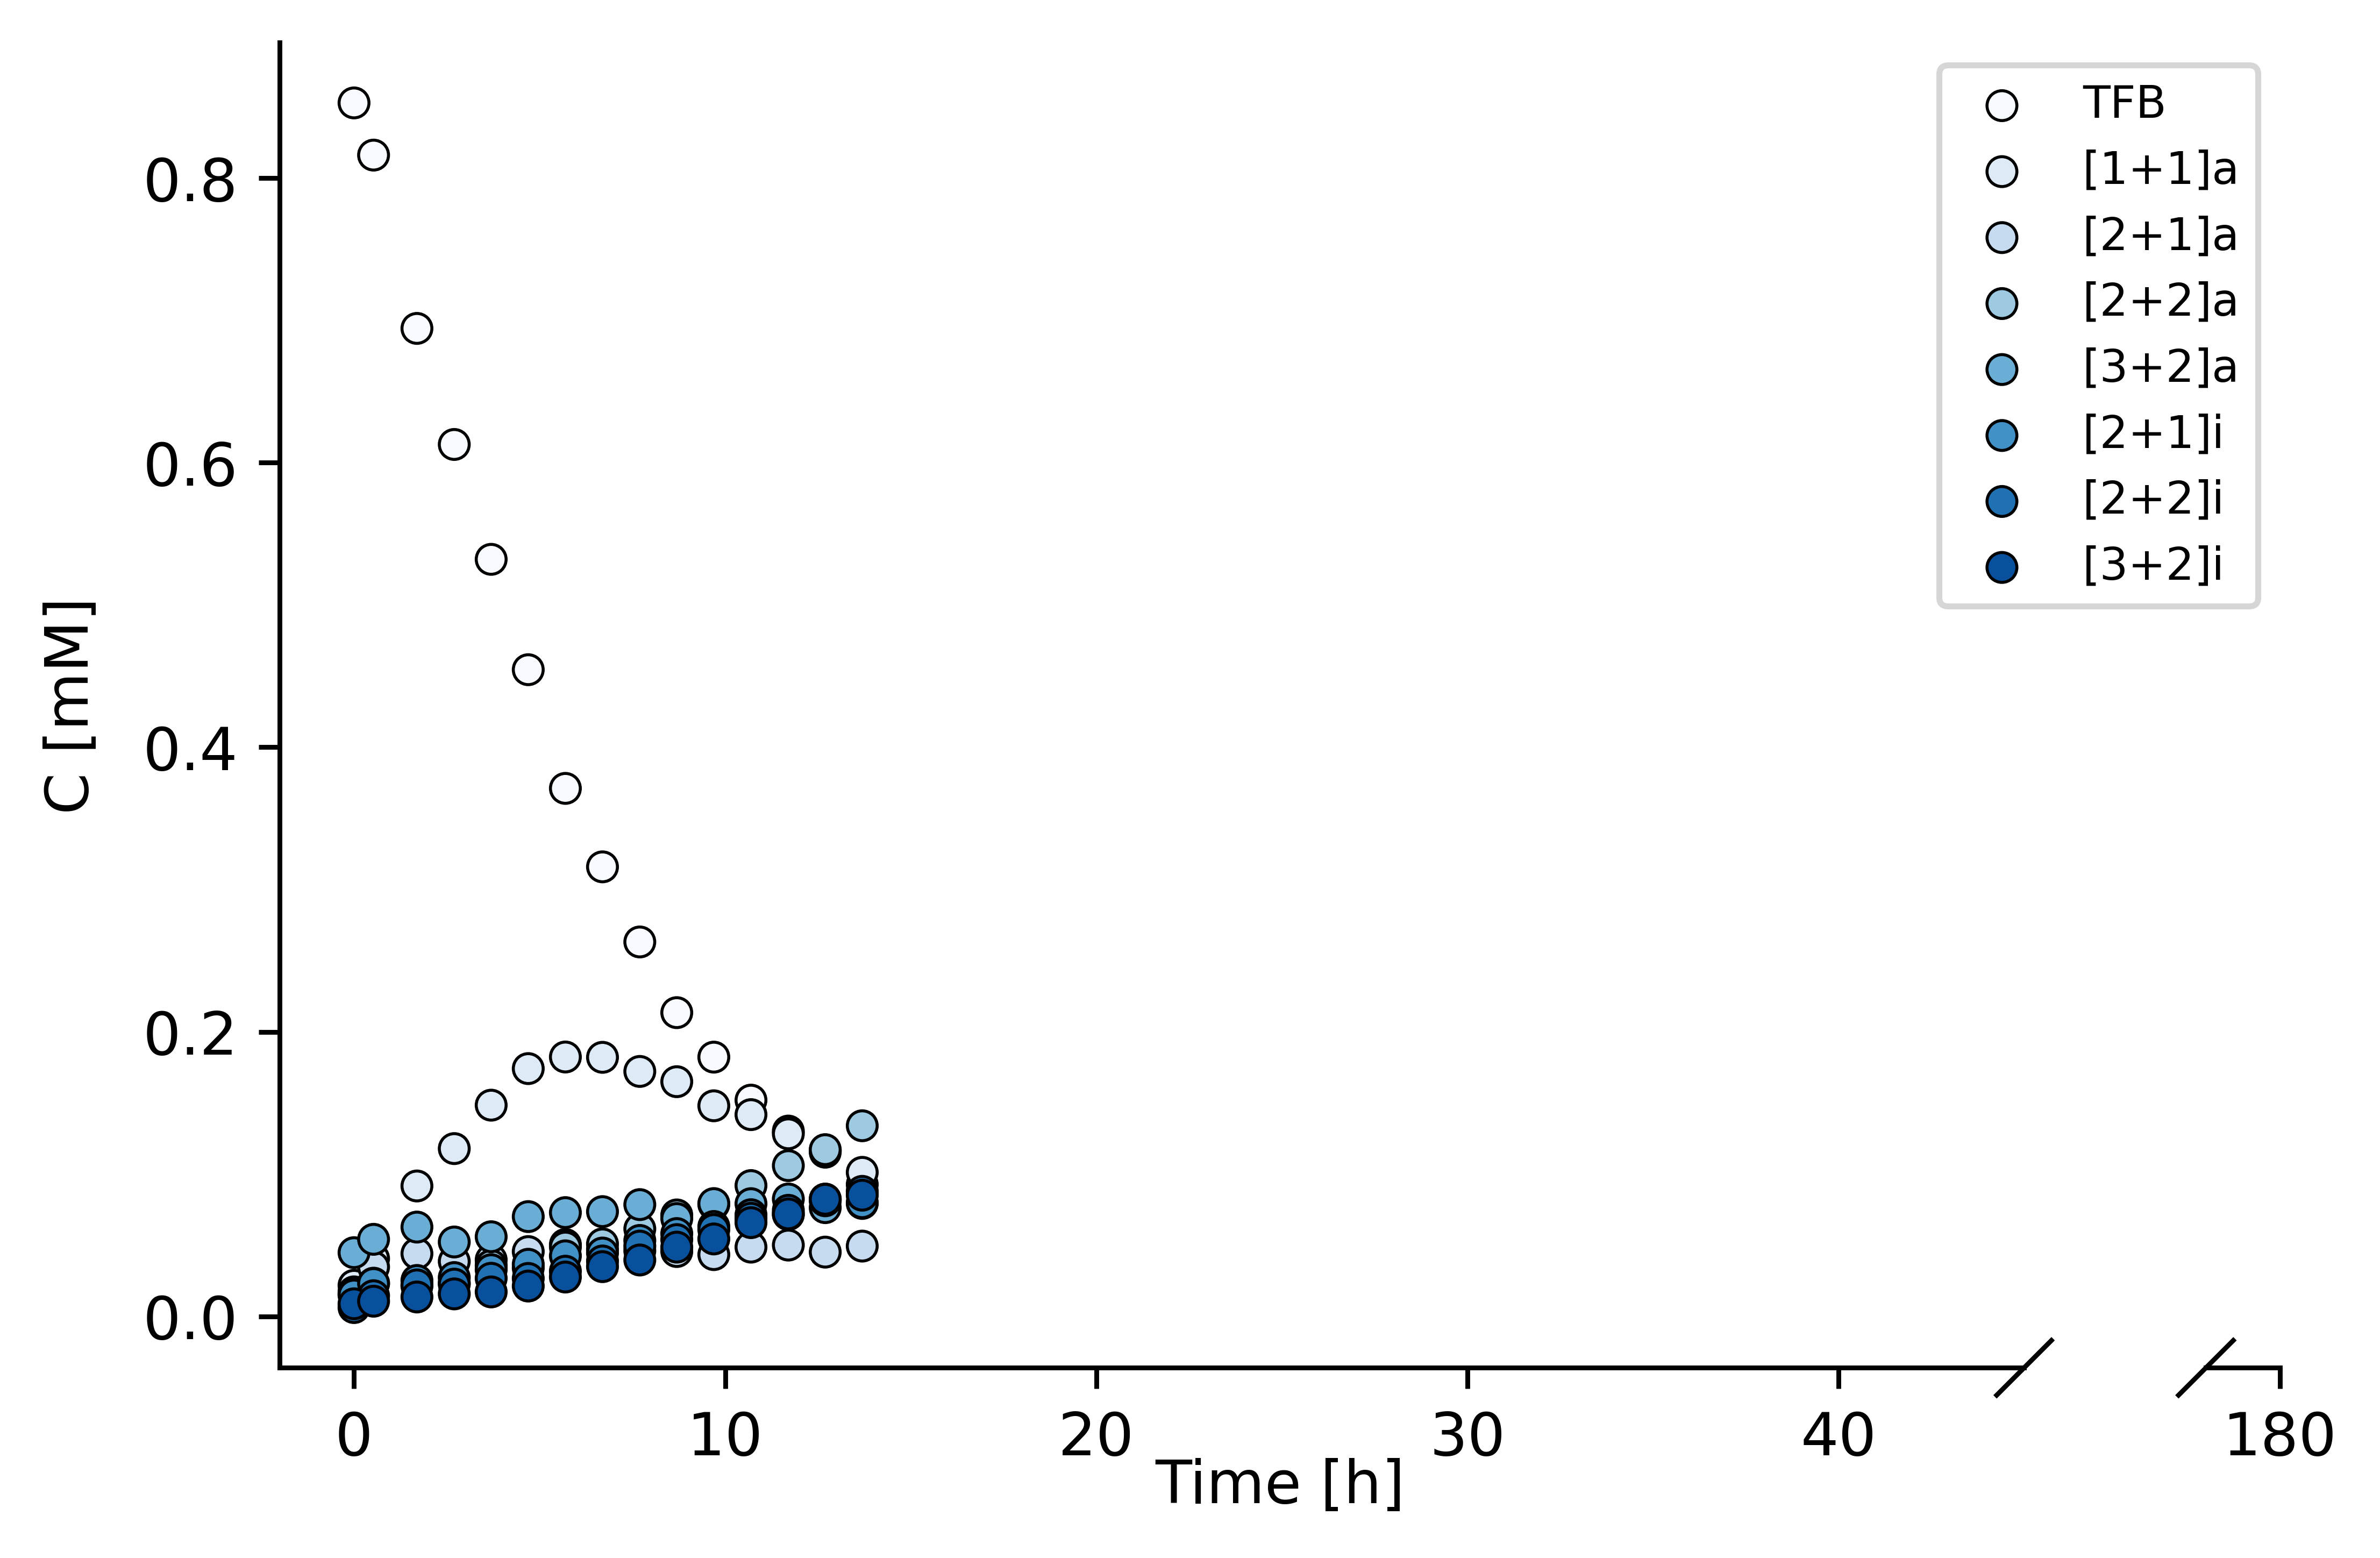

In [ ]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Define your own lists for colormaps and marker types
colormaps = ['Blues']  # Replace 'Blacks' with a valid colormap name
marker_types = ['o']

# Replace the placeholder DataFrame with your actual DataFrame (mean_df)
# Modify your input data to match your DataFrame structure
time = mean_df['time']
data_columns = mean_df.columns[1:-1]

# Create a figure and brokenaxes instance
fig = plt.figure(figsize=(6, 4), dpi=800)
bax = brokenaxes(xlims=[(-2, 45), (178, 180)])  # Set the x-axis limits where you want the breaks

# Iterate through each DataFrame and create scatter plots with different colormaps, marker types, and sizes
for idx, col in enumerate(data_columns):
    colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])
    marker_type = marker_types[idx % len(marker_types)]
    segmented_colors = [colormap(i / len(data_columns)) for i in range(len(data_columns))]
    label = col  # Use the column name as the label
    bax.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

# Title and labels
# bax.set_title("TFB/NDI (8/1)")
bax.set_xlabel("Time [h]")
bax.set_ylabel('C [mM]')

# Change the legend position to 'center left' with bbox_to_anchor, and set the font size
bax.legend(loc='best', prop={'size': 7.5})

plt.show()

# 3. Test of new features


In [ ]:
import matplotlib.pyplot as plt

# Define your own lists for colormaps and marker types
colormaps = ['Blues']  # Replace 'Blacks' with a valid colormap name
marker_types = ['o']

# Replace the placeholder DataFrame with your actual DataFrame (mean_df)
# Modify your input data to match your DataFrame structure
time = mean_df['time']
data_columns = mean_df.columns[1:-1]

# Create a figure and brokenaxes instance
fig = plt.figure(figsize=(6, 4), dpi=800)
# bax = brokenaxes(xlims=[(-2, 45), (178, 180)])  # Set the x-axis limits where you want the breaks

# Iterate through each DataFrame and create scatter plots with different colormaps, marker types, and sizes
for idx, col in enumerate(data_columns):
    colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])
    marker_type = marker_types[idx % len(marker_types)]
    segmented_colors = [colormap(i / len(data_columns)) for i in range(len(data_columns))]
    label = col  # Use the column name as the label
    bax.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

# Create a zoomed-in inset axes within the existing plot
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])

# Set the limits for the zoomed inset axes
axins.set_xlim(0, 15)
axins.set_ylim(0.0, 0.2)

# Display the same data within the zoomed inset axes
for idx, col in enumerate(data_columns):
    label = col  # Use the column name as the label
    axins.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

# Indicate the zoomed region in the main plot
bax.indicate_inset_zoom(axins)

# Title and labels
# bax.set_title("TFB/NDI (8/1)")
ax.set_xlabel("Time [h]")
ax.set_ylabel('C [mM]')

# Change the legend position to 'best' and set the font size
ax.legend(loc='best', prop={'size': 7.5})

plt.show()


<ipython-input-7-4f3c748612a7>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])


NameError: ignored

<Figure size 4800x3200 with 0 Axes>

<ipython-input-9-584d7b27d008>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])


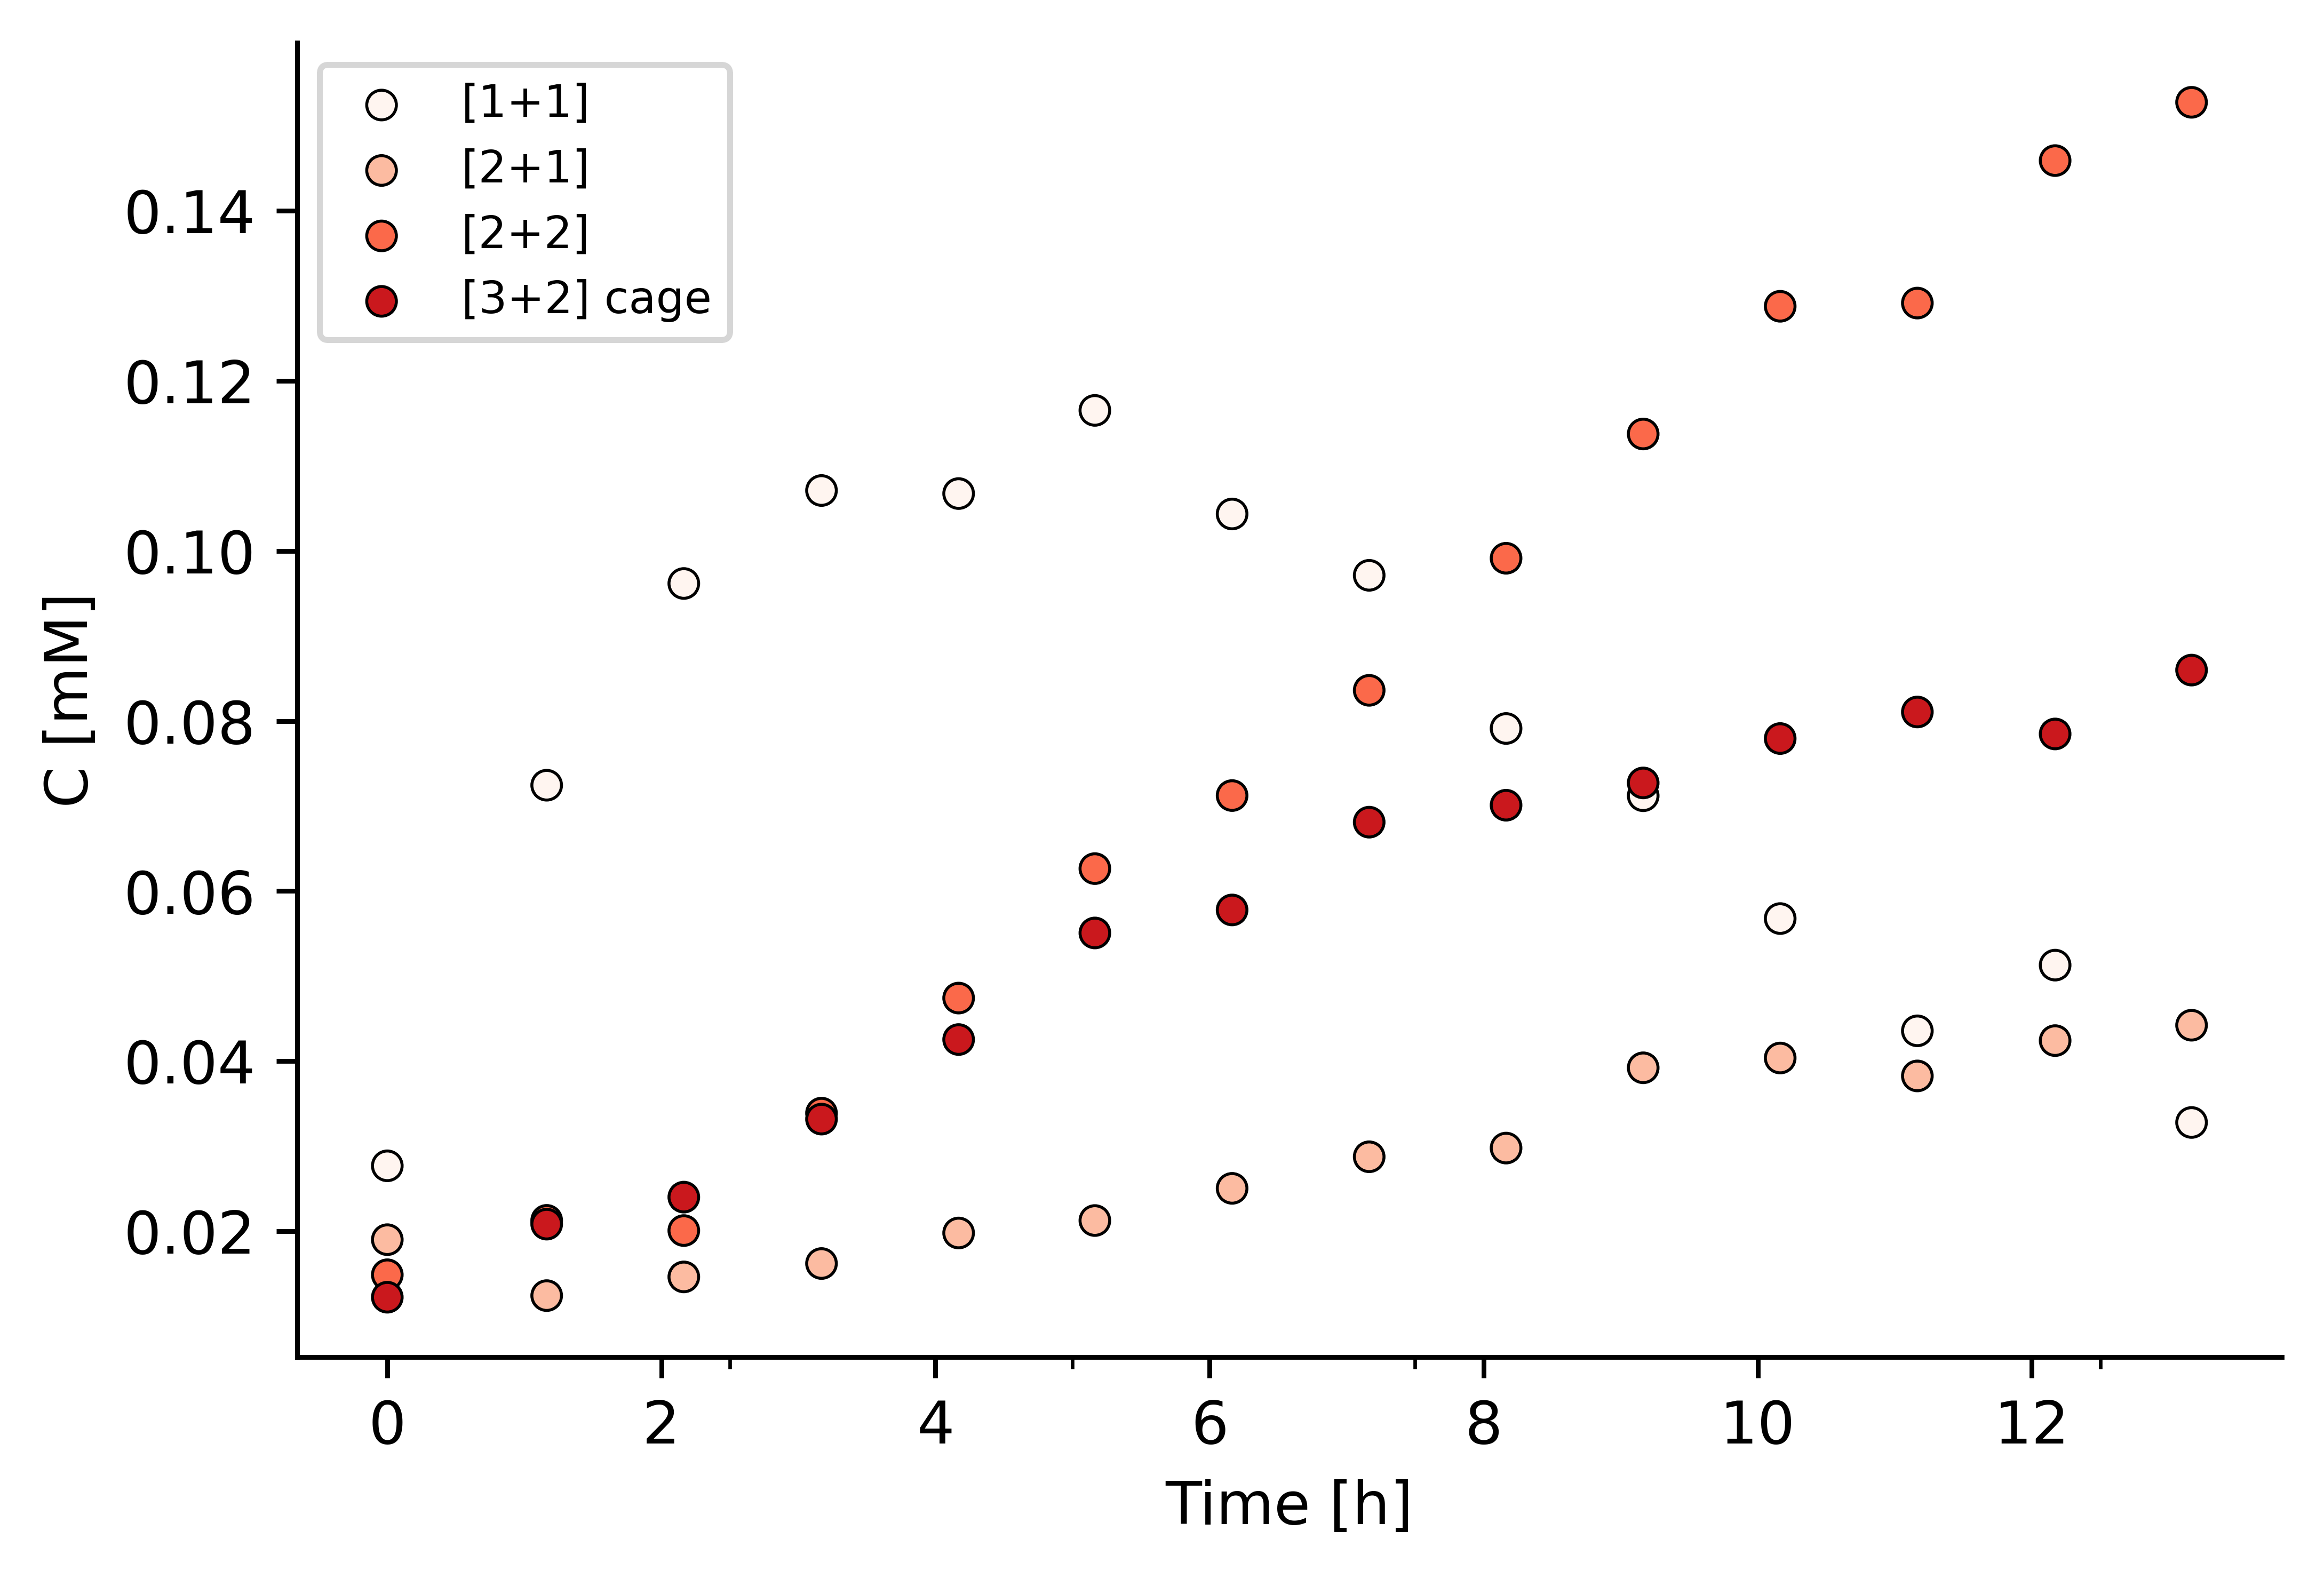

In [ ]:
import matplotlib.pyplot as plt

# Define your own lists for colormaps and marker types
colormaps = ['Reds']  # Replace 'Blacks' with a valid colormap name
marker_types = ['o']

# Replace the placeholder DataFrame with your actual DataFrame (mean_df)
# Modify your input data to match your DataFrame structure
time = mean_df['time']
data_columns = mean_df.columns[1:-1]

# Create a figure and the main axes
fig, ax = plt.subplots(figsize=(6, 4), dpi=800)

# Iterate through each DataFrame and create scatter plots with different colormaps, marker types, and sizes
for idx, col in enumerate(data_columns):
    colormap = plt.cm.get_cmap(colormaps[idx % len(colormaps)])
    marker_type = marker_types[idx % len(marker_types)]
    segmented_colors = [colormap(i / len(data_columns)) for i in range(len(data_columns))]
    label = col  # Use the column name as the label
    ax.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

# Create a zoomed-in inset axes within the existing plot
#axins = ax.inset_axes([0.3, 0.535, 0.45, 0.45])

# Set the limits for the zoomed inset axes
#axins.set_xlim(-0.3, 14)
#axins.set_ylim(0, 0.25)

# Display the same data within the zoomed inset axes
for idx, col in enumerate(data_columns):
    label = col  # Use the column name as the label
    axins.scatter(time, mean_df[col], label=label, c=[segmented_colors[idx]] * len(time), edgecolors='black', linewidth=0.5, marker=marker_type, s=25)

# Indicate the zoomed region in the main plot
# ax.indicate_inset_zoom(axins)

# Removing the spines for the main figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Remove the spines (borders) of the inset axes
# axins.spines['top'].set_visible(False)
# axins.spines['right'].set_visible(False)


# Title and labels
ax.set_xlabel("Time [h]")
ax.set_ylabel('C [mM]')

# Add minor ticks to both x and y axes
ax.minorticks_on()
#axins.minorticks_on()

# Customize the placement of minor ticks on the x and y axes
ax.xaxis.set_minor_locator(plt.MultipleLocator(2.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))

#axins.xaxis.set_minor_locator(plt.MultipleLocator(1))
#axins.yaxis.set_minor_locator(plt.MultipleLocator(0.02))

# Change the legend position to 'best' and set the font size
ax.legend(loc='best', prop={'size': 7.5})

plt.show()